In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.impute import SimpleImputer
import category_encoders as ce  # May need to pip install

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import calinski_harabasz_score


import warnings
warnings.filterwarnings('ignore')

## Section 1: Ingesting data and pre processing

Steps:

- Ingest data
- Drop columns with > 50% observations missing
- For the remaining missing columns, impute mean for numeric types
- For the categorical columns with missing values, add a missing category
- One hot encode all categorical variables
- Create a list of features and target variable

In [2]:
# Ingest the data
data = '../Data/accident_data.csv'
df = pd.read_csv(data)
df.head()

,CRASH_CRN,DISTRICT,CRASH_COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,LANE_COUNT,RDWY_ORIENT,ROAD_OWNER,ROUTE,SPEED_LIMIT,SEGMENT,OFFSET,STREET_NAME,TOT_INJ_COUNT,SCHOOL_BUS_UNIT
0,2004000001,11,2,2454,02454,2004,1,5,257.0,2.0,...,2.0,E,2.0,2032,35.0,10.0,1000.0,LEWIS RUN RD,NaN,NaN
1,2004000010,11,2,2440,02440,2004,1,5,1027.0,10.0,...,2.0,W,3.0,NaN,35.0,NaN,NaN,COAL VALLEY RD,NaN,NaN
2,2004000016,11,2,2203,02203,2004,1,5,1839.0,18.0,...,2.0,W,2.0,3082,35.0,NaN,NaN,CLINTON FRANKFORT RD,NaN,NaN
3,2004000022,11,2,2404,02404,2004,1,6,914.0,9.0,...,2.0,N,4.0,NaN,25.0,NaN,NaN,NORTH BALPH AV,NaN,NaN
4,2004000030,11,2,2419,02419,2004,1,5,2230.0,22.0,...,2.0,S,4.0,NaN,20.0,NaN,NaN,THORNBERRY DR,NaN,NaN


In [3]:
# What variables have missing values, how much and is that variable relevant

# Data dictionary
data_dict = '../Data/accident_data_dict.csv'
data_dict = pd.read_csv(data_dict)

# Missing columns in data
prop_missing = df.isna().mean()

# create a new dataframe with the 'column' and 'prop_missing' variables
missing_df = pd.DataFrame({'column': prop_missing.index, 'prop_missing': prop_missing.values})
missing_df = missing_df[missing_df.prop_missing > 0]

print(f"There are {len(missing_df)} variables which have some missing values. The table below shows the variable, it's description and what proportion is missing")

# Display table
missing_df = pd.merge(missing_df, data_dict, on='column', how='inner')
missing_df.sort_values(by='prop_missing', ascending=False).head(20)

There are 47 variables which have some missing values. The table below shows the variable, it's description and what proportion is missing


,column,prop_missing,type,label,description
16,SPEC_JURIS_CD,0.994239,text,Special Jurisdiction Code,Code that defines any special jurisdiction – o...
15,RDWY_SURF_TYPE_CD,0.994202,text,Roadway Surface Type Code\t,Code for the Roadway surface type –only for fa...
23,WZ_CLOSE_DETOUR,0.992037,text,Work Zone Closed Detour\t,Was traffic rerouted due to work zone?(Y/N); 0...
28,WZ_OTHER,0.991746,text,Work Zone Special Flag\t,Was this a special type of work zone? (Y/N) 0 ...
24,WZ_FLAGGER,0.991645,text,Work Zone Flagman Flag\t,"Did Work zone have a flagman? (Y/N) 0 = No, 1 ..."
27,WZ_MOVING,0.991409,text,Work Zone Moving Flag\t,Was there moving work in the zone? (Y/N) 0 = N...
29,WZ_SHLDER_MDN,0.989960,text,Work Zone Shoulder/Median Flag\t,Was a median/shoulder in the zone?; (Y/N) 0 = ...
26,WZ_LN_CLOSURE,0.988044,text,Work Zone Lane Closure Flag\t,"Did Work zone have a patrolman? (Y/N) 0 = No, ..."
21,CONS_ZONE_SPD_LIM,0.982874,int4,Construction Zone Speed Limit,Speed limit for the Construction Zone
25,WZ_LAW_OFFCR_IND,0.982864,text,Work Zone Patrolman Flag\t,"Did Work zone have a patrolman? (Y/N) 0 = No, ..."


In [4]:
# Dealing with missing values

# Logic: If a variable has more than 50% of observations missing, drop that variable
# Logic: Else, if it's an int variable, impute mean. If it's a text variable, create a missing category

# Drop vars
clean_df = df.copy()
vars_to_drop = list(missing_df[missing_df.prop_missing>=0.5]['column'])
clean_df = df.drop(columns=vars_to_drop, axis=1)

# Impute mean for missing values in numerical columns
numerical_cols = clean_df.select_dtypes(include=['int', 'float']).columns
imputer = SimpleImputer(strategy='mean')
clean_df[numerical_cols] = imputer.fit_transform(clean_df[numerical_cols])

# Add a missing category and make text columns categorical
# For this we have to refer to the data_dict to see which columns are of type text
text_cols = clean_df.select_dtypes(include=['object']).columns
var_types = data_dict.set_index('column')['type'].to_dict()
text_vars = [var for var in var_types.keys() if var_types[var] == 'text' 
             and var not in vars_to_drop 
             and 'CRN' not in var # These are unique identifiers
             and 'TUDE' not in var # Don't want to encode lat longs  
             and 'DEC_L' not in var # Don't want to encode lat longs  
             and 'STREET_NAME' not in var] # Don't want to encode street name as too many values  

clean_df[text_vars] = clean_df[text_vars].fillna('missing').astype('category')


In [5]:
# Encoding categorical variables (takes some time to run, ~ 2 mins)
cat_vars = text_vars
# Initialize the OneHotEncoder from category_encoders
one_hot_enc = ce.OneHotEncoder(cols=cat_vars, use_cat_names=True)

# Fit the encoder on your data and transform the data
cat_encoded = one_hot_enc.fit_transform(clean_df[cat_vars])
df_encoded = pd.concat([clean_df.drop(cat_vars, axis=1), cat_encoded], axis=1)

In [6]:
# Store feature and target vars to be used in the next section
feature_vars = [var for var in df_encoded.columns if 'CRN' not in var
                and 'TUDE' not in var
                and 'DEC_L' not in var
                and 'STREET_NAME' not in var
                and 'FATAL_OR_MAJ_INJ' not in var
                and 'INJ' not in var and 'FATAL' not in var
                and 'COUNT' not in var and 'MAX_SEVERITY_LEVEL' not in var] # The last 4 are vars which one won't observe during prediction time and hence cause leakage

target_var = 'FATAL_OR_MAJ_INJ'

## Section 2: Unsupervised Algorithms

### Clustering

In [7]:
# Separate features from output variables

vehicle_features = ['MOTORCYCLE','BICYCLE','HVY_TRUCK_RELATED','VEHICLE_FAILURE','TRAIN_TROLLEY','PHANTOM_VEHICLE', 'SCHOOL_BUS', 'FIRE_IN_VEHICLE',
                    'COMM_VEHICLE']

road_features = ['INTERSTATE','STATE_ROAD', 'LOCAL_ROAD','LOCAL_ROAD_ONLY', 'TURNPIKE', 'WET_ROAD', 'SNOW_SLUSH_ROAD', 'ICY_ROAD','SHLDR_RELATED', 'REAR_END',
'HO_OPPDIR_SDSWP', 'HIT_FIXED_OBJECT', 'SV_RUN_OFF_RD', 'WORK_ZONE', 'PROPERTY_DAMAGE_ONLY', 'NON_INTERSECTION', 'INTERSECTION', 'SIGNALIZED_INT',
'STOP_CONTROLLED_INT', 'UNSIGNALIZED_INT', 'SCHOOL_ZONE', 'CURVED_ROAD']

driver_features = ['ALCOHOL_RELATED', 'DRINKING_DRIVER','UNDERAGE_DRNK_DRV','UNLICENSED','CELL_PHONE', 'NO_CLEARANCE', 'RUNNING_RED_LT', 'TAILGATING',
'CROSS_MEDIAN', 'CURVE_DVR_ERROR', 'LIMIT_65MPH', 'SPEEDING', 'SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'FATIGUE_ASLEEP', 'DRIVER_16YR', 'DRIVER_17YR',
'DRIVER_65_74YR', 'DRIVER_75PLUS', 'UNBELTED', 'DISTRACTED', 'DRIVER_18YR','DRIVER_19YR', 'DRIVER_20YR', 'DRIVER_50_64YR', 'HIT_PARKED_VEHICLE','MC_DRINKING_DRIVER',
'DRUGGED_DRIVER','IMPAIRED_DRIVER','DRUG_RELATED','HAZARDOUS_TRUCK','ILLEGAL_DRUG_RELATED']


X_v = df_encoded[vehicle_features]
X_r = df_encoded[road_features]
X_d = df_encoded[driver_features]

# Scale the features
sc = StandardScaler()
 
X_v = sc.fit_transform(X_v)
X_r = sc.fit_transform(X_r)
X_d = sc.fit_transform(X_d)

### Vehicle Features

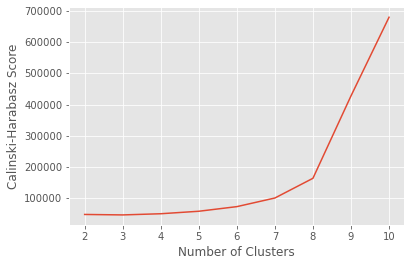

In [8]:
# Define range of clusters to test
num_clusters = range(2, 11)

# Calculate Calinski-Harabasz score for each cluster
ch_scores = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_v)
    ch_scores.append(calinski_harabasz_score(X_v, kmeans.labels_))

# Plot Calinski-Harabasz scores against number of clusters
plt.plot(num_clusters, ch_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

In [9]:
# create a KMeans object with k=10 clusters

k = 10
kmeans = KMeans(n_clusters=k, random_state=200)

# fit the KMeans object to the features matrix
kmeans.fit(X_v)

# get the cluster labels for each bigram
cluster_labels_vehicle = kmeans.labels_

# add the cluster labels to the DataFrame
cluster_labels_vehicle

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [10]:
clustered_data_vehicle = pd.concat([pd.DataFrame(X_v), pd.Series(cluster_labels_vehicle, name='label')], axis=1)
clustered_data_vehicle


,0,1,2,3,4,5,6,7,8,label
0,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
1,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
2,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
3,-0.154526,-0.083053,5.255464,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,4.514675,1
4,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
...,...,...,...,...,...,...,...,...,...,...
216619,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
216620,-0.154526,12.040475,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,2
216621,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0
216622,-0.154526,-0.083053,-0.190278,-0.239085,-0.020724,-0.083643,-0.086261,-0.064193,-0.221500,0


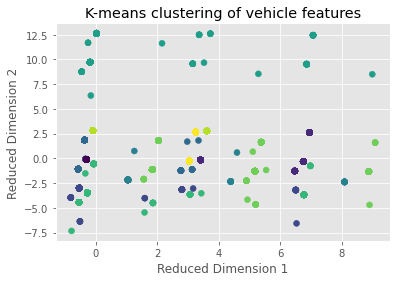

In [11]:
# reduce the dimensionality of the feature matrix to 2 dimensions using PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_v)

# create a scatter plot of the first two principal components, colored by cluster labels
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels_vehicle)
plt.xlabel('Reduced Dimension 1')
plt.ylabel('Reduced Dimension 2')
plt.title('K-means clustering of vehicle features')
plt.show()

### Road Features

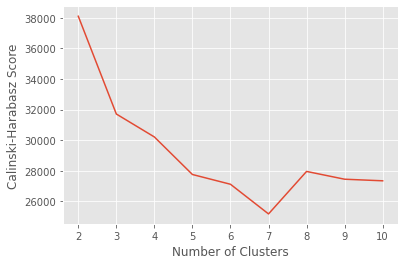

In [12]:
# Define range of clusters to test
num_clusters = range(2, 11)

# Calculate Calinski-Harabasz score for each cluster
ch_scores = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_r)
    ch_scores.append(calinski_harabasz_score(X_r, kmeans.labels_))

# Plot Calinski-Harabasz scores against number of clusters
plt.plot(num_clusters, ch_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

In [13]:

# create a KMeans object with k=2 clusters

k = 2
kmeans = KMeans(n_clusters=k, random_state=200)

# fit the KMeans object to the features matrix
kmeans.fit(X_r)

# get the cluster labels for each bigram
cluster_labels_roads = kmeans.labels_

# add the cluster labels to the DataFrame
cluster_labels_roads



array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [14]:
clustered_data_roads = pd.concat([pd.DataFrame(X_r), pd.Series(cluster_labels_roads, name='label')], axis=1)
clustered_data_roads

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,label
0,-0.325495,0.837273,-1.169551,-0.791573,-0.108402,-0.469647,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,0.939628,0.877673,-0.877648,-0.458819,-0.349938,-0.594610,-0.054818,-0.467947,1
1,-0.325495,-1.194353,0.907020,1.263308,-0.108402,-0.469647,-0.205885,4.665210,-0.027942,-0.601006,...,-0.134177,-1.064251,0.877673,-0.877648,-0.458819,-0.349938,-0.594610,-0.054818,2.136992,1
2,-0.325495,0.837273,-1.169551,-0.791573,-0.108402,-0.469647,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,-1.064251,-1.139376,1.139408,-0.458819,2.857650,1.681773,-0.054818,-0.467947,0
3,-0.325495,-1.194353,0.907020,1.263308,-0.108402,2.129259,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,-1.064251,-1.139376,1.139408,2.179510,-0.349938,-0.594610,-0.054818,-0.467947,0
4,-0.325495,-1.194353,0.907020,1.263308,-0.108402,-0.469647,-0.205885,-0.214353,-0.027942,1.663877,...,-0.134177,0.939628,0.877673,-0.877648,-0.458819,-0.349938,-0.594610,-0.054818,-0.467947,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216619,-0.325495,0.837273,-1.169551,-0.791573,-0.108402,2.129259,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,0.939628,0.877673,-0.877648,-0.458819,-0.349938,-0.594610,-0.054818,-0.467947,1
216620,-0.325495,-1.194353,0.907020,1.263308,-0.108402,-0.469647,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,-1.064251,-1.139376,1.139408,2.179510,-0.349938,-0.594610,-0.054818,-0.467947,0
216621,-0.325495,0.837273,0.907020,-0.791573,-0.108402,-0.469647,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,0.939628,-1.139376,1.139408,2.179510,-0.349938,-0.594610,-0.054818,-0.467947,0
216622,3.072248,0.837273,-1.169551,-0.791573,-0.108402,2.129259,-0.205885,-0.214353,-0.027942,-0.601006,...,-0.134177,-1.064251,0.877673,-0.877648,-0.458819,-0.349938,-0.594610,-0.054818,2.136992,1


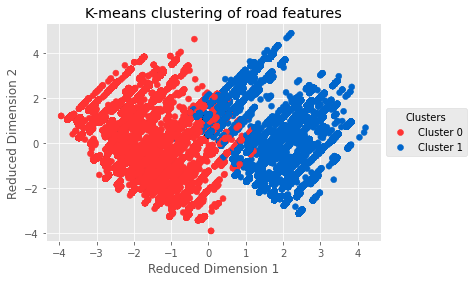

In [15]:
# reduce the dimensionality of the feature matrix to 2 dimensions using PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_r)

# create a scatter plot of the first two principal components, colored by cluster labels

sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=cluster_labels_roads, palette=['#FF3333', '#0066CC'], edgecolor=None)

# Add cluster labels to the legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Cluster {}'.format(int(label)) for label in labels]
plt.legend(handles, labels, title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Reduced Dimension 1')
plt.ylabel('Reduced Dimension 2')
plt.title('K-means clustering of road features')
plt.show()


##### It seems like road characteristics separate out accidents neatly into clusters


Text(0.5, 1.0, 'Outcome Label by Road Cluster')

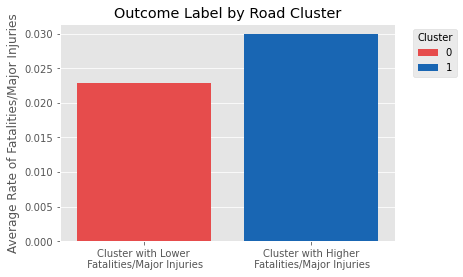

In [16]:
# Cluster means

group_mean = pd.concat([df_encoded['FATAL_OR_MAJ_INJ'], clustered_data_roads['label']], axis=1).groupby('label').mean().reset_index()

# Plot bar graph
fig, ax = plt.subplots( )
sns.barplot(data=group_mean, y='FATAL_OR_MAJ_INJ', x='label', hue='label', dodge=False, palette=['#FF3333', '#0066CC'])
ax.set_ylabel('Average Rate of Fatalities/Major Injuries')
ax.set_xlabel('')
ax.set_xticklabels(['Cluster with Lower\n Fatalities/Major Injuries','Cluster with Higher\n Fatalities/Major Injuries'],  ha='center')
plt.legend(bbox_to_anchor=(1.2,1), loc='upper right', title='Cluster')
plt.title('Outcome Label by Road Cluster')



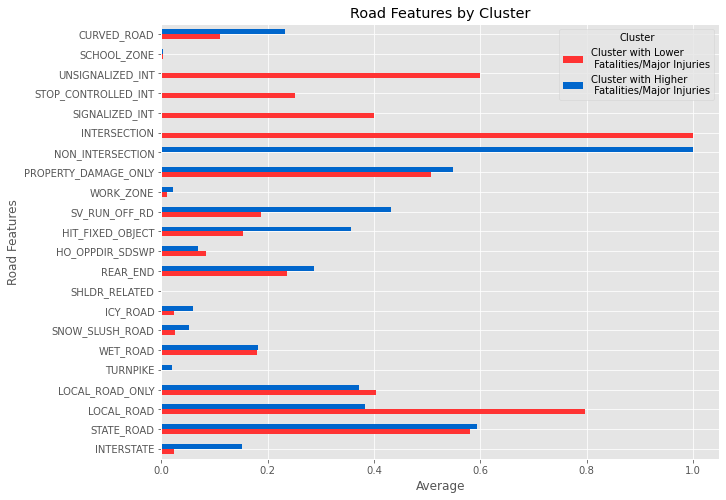

In [17]:
# Cluster means

group_mean_road = pd.concat([df_encoded[road_features], clustered_data_roads['label']], axis=1).groupby('label').mean().transpose()

# Plot bar graph
fig, ax = plt.subplots(figsize=(10,8))
group_mean_road.plot(ax=ax, kind='barh',color=['#FF3333', '#0066CC'])
ax.set_ylabel('Road Features')
ax.set_xlabel('Average')
legend = ax.legend(bbox_to_anchor=(1,1), loc='upper right', title='Cluster')
legend.texts[0].set_text('Cluster with Lower\n Fatalities/Major Injuries')
legend.texts[1].set_text('Cluster with Higher\n Fatalities/Major Injuries')
plt.title('Road Features by Cluster')

plt.show()


### Driver Features

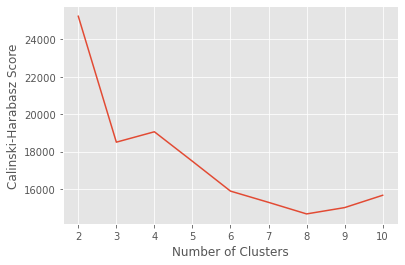

In [18]:
# Define range of clusters to test
num_clusters = range(2, 11)

# Calculate Calinski-Harabasz score for each cluster
ch_scores = []
for n in num_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_d)
    ch_scores.append(calinski_harabasz_score(X_d, kmeans.labels_))

# Plot Calinski-Harabasz scores against number of clusters
plt.plot(num_clusters, ch_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

In [19]:

# create a KMeans object with k=3 clusters

k = 2
kmeans = KMeans(n_clusters=k)

# fit the KMeans object to the features matrix
kmeans.fit(X_d)

# get the cluster labels for each bigram
cluster_labels_driver = kmeans.labels_

# add the cluster labels to the DataFrame
cluster_labels_driver


array([1, 0, 0, ..., 0, 1, 0], dtype=int32)

In [20]:
clustered_data_driver = pd.concat([pd.DataFrame(X_d), pd.Series(cluster_labels_driver, name='label')], axis=1)
clustered_data_driver

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,3.167774,3.218234,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,2.966217,-0.150918,-0.027609,-0.103365,1
1,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,1.567947,-0.288014,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
2,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
3,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,1.567947,-0.288014,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
4,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,3.472052,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216619,3.167774,3.218234,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,2.966217,-0.150918,-0.027609,-0.103365,1
216620,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
216621,-0.315679,-0.310729,-0.073533,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,-0.337130,-0.150918,-0.027609,-0.103365,0
216622,3.167774,3.218234,13.599388,-0.056856,-0.106689,-0.250119,-0.188316,-0.232121,-0.118124,-0.190252,...,-0.216546,-0.637777,-0.288014,-0.04613,-0.150052,2.966217,-0.150918,-0.027609,-0.103365,1


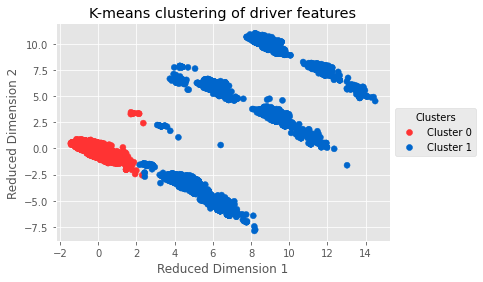

In [21]:
# reduce the dimensionality of the feature matrix to 2 dimensions using PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_d)

# create a scatter plot of the first two principal components, colored by cluster labels

# create a scatter plot of the first two principal components, colored by cluster labels

sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=cluster_labels_driver, palette=['#FF3333', '#0066CC'], edgecolor=None)

# Add cluster labels to the legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Cluster {}'.format(int(label)) for label in labels]
plt.legend(handles, labels, title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Reduced Dimension 1')
plt.ylabel('Reduced Dimension 2')
plt.title('K-means clustering of driver features')
plt.show()


##### It seems like driver characteristics also separate out accidents neatly into clusters

Text(0.5, 1.0, 'Outcome Label by Driver Cluster')

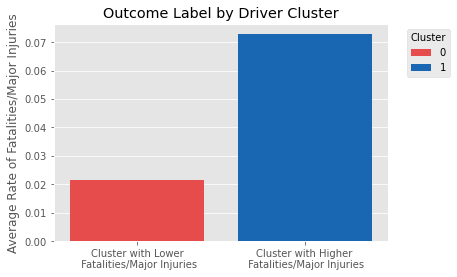

In [22]:
# Cluster means

group_mean = pd.concat([df_encoded['FATAL_OR_MAJ_INJ'], clustered_data_driver['label']], axis=1).groupby('label').mean().reset_index()

# Plot bar graph
fig, ax = plt.subplots()
sns.barplot(data=group_mean, y='FATAL_OR_MAJ_INJ', x='label', hue='label', dodge=False, palette=['#FF3333', '#0066CC'])
ax.set_ylabel('Average Rate of Fatalities/Major Injuries')
ax.set_xlabel('')
ax.set_xticklabels(['Cluster with Lower\n Fatalities/Major Injuries','Cluster with Higher\n Fatalities/Major Injuries'],  ha='center')
plt.legend(bbox_to_anchor=(1.2,1), loc='upper right', title='Cluster')
plt.title('Outcome Label by Driver Cluster')

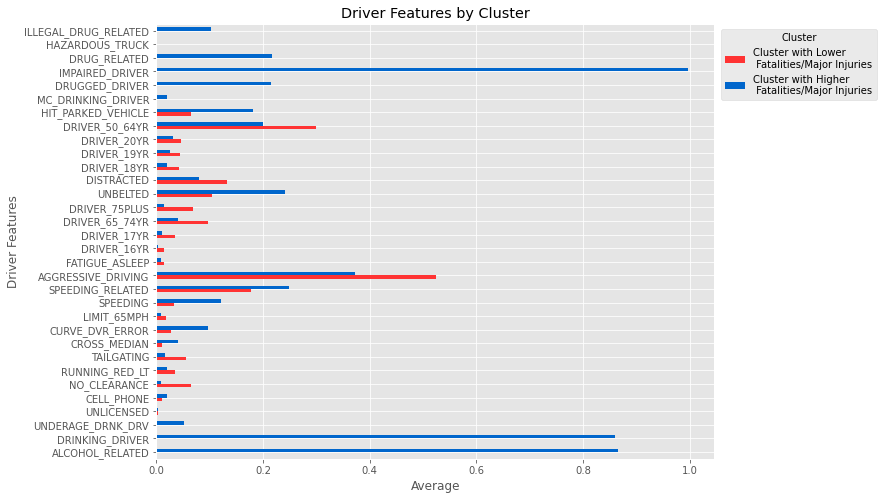

In [25]:
# Cluster means

group_mean_driver = pd.concat([df_encoded[driver_features], clustered_data_driver['label']], axis=1).groupby('label').mean().transpose()

# Plot bar graph
fig, ax = plt.subplots(figsize=(10,8))
group_mean_driver.plot(ax=ax, kind='barh', color=['#FF3333', '#0066CC'])
ax.set_ylabel('Driver Features')
ax.set_xlabel('Average')
legend = ax.legend(bbox_to_anchor=(1.3,1), loc='upper right', title='Cluster')
legend.texts[0].set_text('Cluster with Lower\n Fatalities/Major Injuries')
legend.texts[1].set_text('Cluster with Higher\n Fatalities/Major Injuries')
plt.title('Driver Features by Cluster')
plt.show()

